# Nsaba Walkthrough

Nsaba is a tool that can be used to compare gene expression in brain regions associated with terms often used in the neuroscience literature. 

In other words, this toolbox can ask questions such as, "Is the D2 receptor expressed significantly higher in brain regions that are activated in studies that talk about 'reward'?"

In this notebook I will demonstrate some of the functionality of the Nsaba toolbox to explore the relationship between D2 receptors and reward. 

In [1]:
# settings and modules
%config InlineBackend.figure_format = 'retina'
%pylab inline
from nsaba.nsaba import nsaba
import nsaba.nsaba.geneinfo
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import itertools

Populating the interactive namespace from numpy and matplotlib


The nsaba library contains a class called Nsaba() that has all of the base functionality of loading and organizing genetic expression and activation data.
The module also contains a few other modules:
* Analysis: tools to perform coorelations and ttests on genetic expression and activation.
* Visualizer: tools to visualize relationships between genetic expression and activation.
* Builder: tools to build and save static matrices of genetic expression and activaion.
* geneinfo: tools to querry the NIH gene database to get information about genes




# The Nsaba() base Module


**Useful Methods:**

* get_ns_act(myterm, thresh=-1, method='knn', search_radii=3, k=None): Estimates activation for a term at all points where we have genetic expression data. Thresh sets a minimum value for activation data to load. higher thresh values speed up runtime but are less reflective of varience in the data. Sphere or knn methods can be chosen to estimate activation where the search radius (in voxels) or k nearest neighboring points can be chosen. This data is saved in self.term[myterm]["ns_act_vector"] 

* get_aba_ge([genes]): loads the gene activation at the coordinates where there is data in the ABA. This data is saved as self.ge[yourgene]

* make_ge_ns_mat(ns_term, entrez_ids): makes a matrix of gene expression and activation of a term where there was data close enough to estimate. Entries on the same row are at the same coordinate.

* coords_to_term([(x,y,z),(x,y,z),...],term,search_radii=5): returns the mean activation of a term for a list of coordinates. If there is no data at a coordinate. Activation is estimated using the knn method (described below).

* coords_to_ge(coords, entrez_ids, search_radii=5, k=20): returns the mean expression of a gene for a list of genes. If there is no data at a coordinate. Expression is estimated using the knn method (described below).

**Initialization methods:**

* aba_load(aba_path='.', csv_names=None): loads data from the ABA into dataframes.

* ns_load(ns_path='.', ns_files=None): loads data from NS into dataframes.

* _check_static_members(): really a bookkeeping method. Reminds the user to run aba_load and ns_load before doing anything 


* load_ge_pkl(pkl_file="Nsaba_ABA_ge.pkl", output_dir='.'): loads a previously saved pkl file of genetic expression. Faster than ns_load for a series of genes.

* pickle_ge(pkl_file="Nsaba_ABA_ge.pkl", path='.'): loads a previously saved pkl file.

**Bookkeeping methods:**

* check_entrez_struct(entrez_ids): checks that entrez_id's are entered in the correct format

* is_term(term): checks that a term exists in the NS term library

* is_coord((x,y,z)): checks if a coordinate set has a matching neurosynth study ID

* is_id(study_id): checks if a study ID matches the Neurosynth database. The two dataframes, one with coordinates and one with activation vectors have some mismatched ID's.

* coord_to_ids((x,y,z)): finds study IDs with coordinates that match (x,y,z)

* coord_to_terms((x,y,z)): returns the mean activation of all terms at coordinates (x,y,z). If there is no activation data at these coordinates, it returns []

* _coord_to_ge(coord, ids, search_radii, k): returns the estimated gene expression of a gene at a coordinate using the knn method (described below)

* _id_to_terms(study_id): returns the vector of term activations for a NS study

* id_to_coords. Not a method. Use id_dict.

* _term_to_coords(term, thresh=0): returns coordinates where a term activation is above a given threshold. set thresh to -1 for all activation.

* _sphere, _sphere_method: used together to estimate expression or activation using nearby points by drawing spheres of increasing size and weighting them by distance to the seeded point

* _knn, _knn_method: used together to estimate expression or activation using nearby points using K-nearest-neighbors method. Faster than sphere.

* ns_load_id_dict(): builds a dictionary of NS study ids with their corresponding coordinates. Helpful for NS methods where lots of overlapping data has to be accessed. 

* set_ns_weight_f(f): sets the weighting metric for how to weight nearby activation when estimating NS activation of an unknown point.


### Initializing a Nsaba object

In [2]:
ns_path = "/Users/Torben/Documents/ABI analysis/current_data_new/"
aba_path = '/Users/Torben/Documents/ABI analysis/normalized_microarray_donor9861/'
#nsaba.Nsaba.aba_load(aba_path)
nsaba.nsaba.Nsaba.ns_load(ns_path)
nsaba.nsaba.Nsaba.aba_load(aba_path)
N = nsaba.nsaba.Nsaba()
N.load_ge_pickle(pkl_file='/Users/Torben/Documents/ABI analysis/normalized_microarray_donor9861/Nsaba_ABA_ge.pkl')

database.txt loaded.
features.txt loaded.
Nsaba.ns['mni_coords'] initialized.

SampleAnnot.csv loaded.
MicroarrayExpression.csv loaded.
Probes.csv loaded.
Nsaba.aba['mni_coords'] initialized.

'ge' dictionary successfully loaded


### Gathering data for two genes and two terms
* 'Reward' and 'Motivation' - Words used to describe behaviors associated with basal ganglia circuitry
* entrez ID: 1813 - DRD2, the D2 dopamine receptor
* entrez ID: 6531 - SLC6A3, a gene that encodes the dopamine transporter

It takes a long time to estimate activation at points where there is data for genetic expression. This happens because for every study that NeuroSynth has activation data there are multiple coordinates of activation. Additionally, there are often multiple studies that show activation in identical coordinates. This, and estimating activation in unknown points using nearby known points takes a long time. The thresh parameter in get_ns_act can load a subset of the studies. Setting it at -1 loads all studies. 

In [3]:
term1 = 'reward'
term2 = 'motivation'
genes = [1813 , 6531]
nsaba.nsaba.geneinfo.gene_info(str(genes[0]))
nsaba.nsaba.geneinfo.gene_info(str(genes[1])) 

N.get_ns_act(term1, thresh=-1, method='knn')
N.get_ns_act(term2, thresh=-1, method='knn')

### Estimating term heat and gene expression at coordinates most associated with reward

In [4]:
N.ns_load_id_dict()
coords= N.term_to_coords('reward',no_ids=5)
print coords[0][0:5]
#coords = [(52.0, -4.0, -2.0),(-56.0, -6.0, 0.0),(2,2,-2)]

estimated_activation= N.coords_to_term(coords[0][0:5],'reward',search_radii=8)

estimated_ge= N.coords_to_ge(coords[0][0:5],[genes[0]],search_radii=8)

print "Estimated Activation at coordinates:" + str(np.mean(estimated_activation))
print "Estimated gene expression at coordinates:" + str(np.mean(np.squeeze(estimated_ge)))


[(52.0, -4.0, -2.0), (-56.0, -6.0, 0.0), (10.0, 6.0, -6.0), (-10.0, 8.0, -6.0), (14.0, -4.0, -8.0)]
Estimated Activation at coordinates:0.0438524475334
Estimated gene expression at coordinates:3.98358640336


# The Visualization module

* visualize_ge(gene): plots all of the points where there is genetic expression where color corresponds to genetic expression.

* visualize_ns(term,no_ids): plots the coordinates most associated with the given term where color corresponds to term frequency.

* visualize_ns_ns(term1,term2): plots the activation of two terms against eachother. Returns linear regression coefficients and r^2.

* visualize_ge_ge([gene1,gene2]): plots the expression of two genes against eachother. Returns linear regression coefficients and r^2.

* visualize_ge_ns(term, gene): plots the correlation between term activation and gene expression. Returns linear regression coefficients and r^2.

### Visualizing  gene expression of two genes

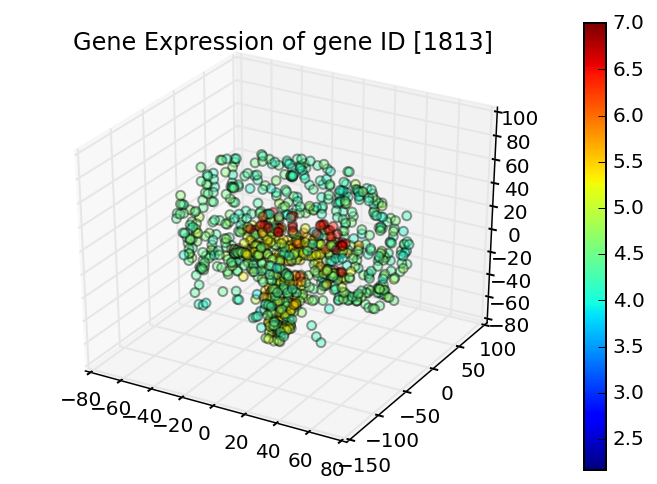

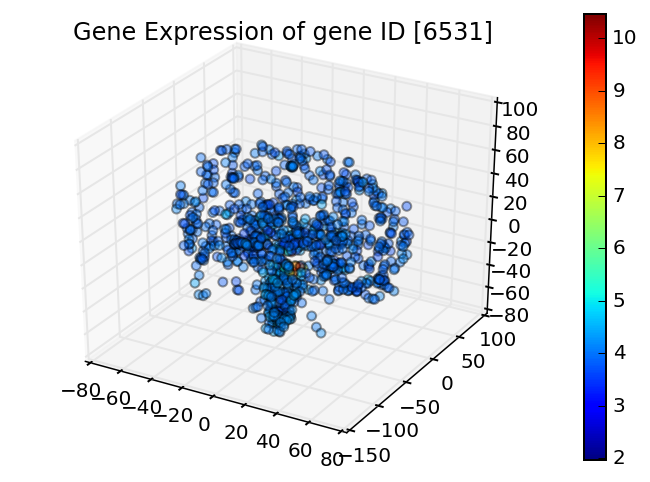

In [5]:
from nsaba.nsaba.visualizer import NsabaVisualizer
V = NsabaVisualizer(N)
V.visualize_ge([genes[0]])
V.visualize_ge([genes[1]])

### Visualizing activation of 2 terms

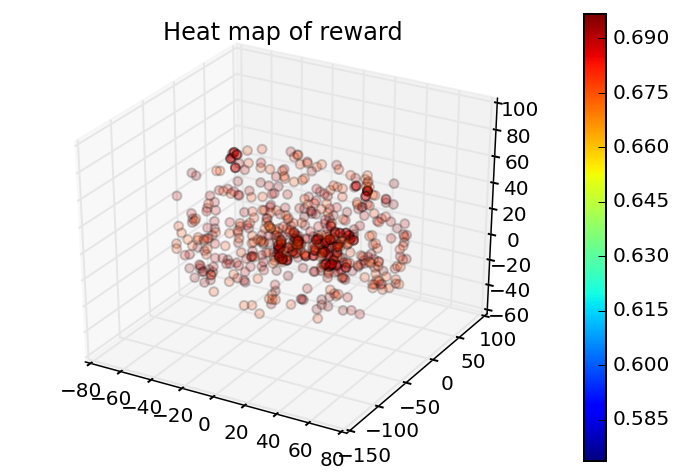

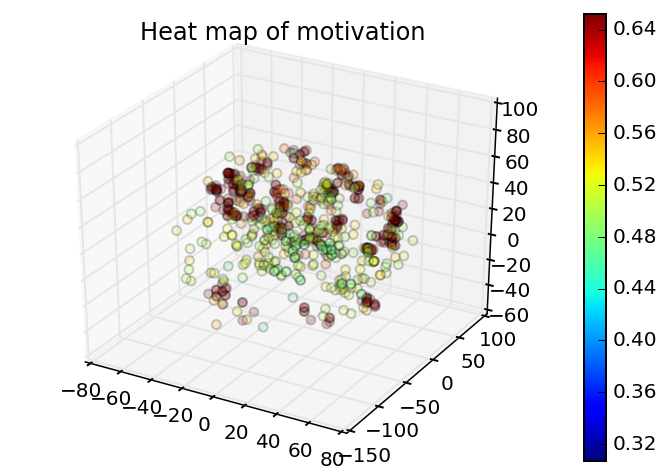

In [6]:
V.visualize_ns('reward',no_ids = 20)
V.visualize_ns('motivation',no_ids = 20)

### Plotting the correlation between two genes

(array([[ 1.        ,  0.35283388],
        [ 0.35283388,  1.        ]]),
 [0.33555195928373605, 1.3717596592325352])

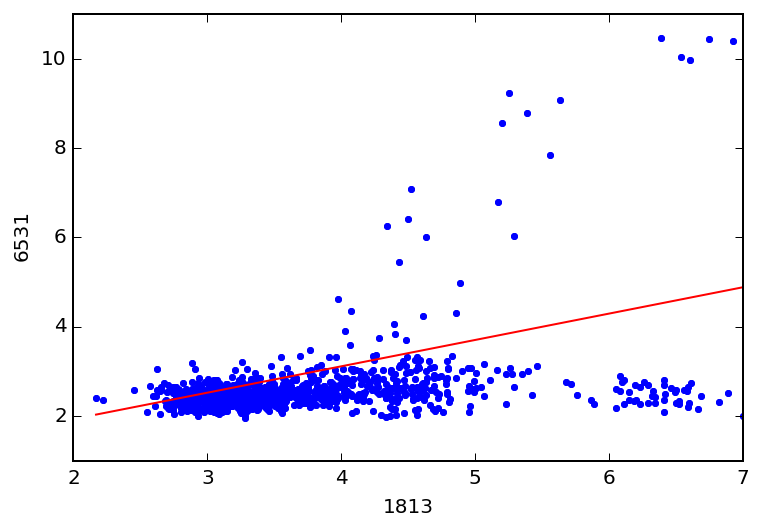

In [7]:
V.visualize_ge_ge(genes)

Interesting note:
We're plotting the gene expression of the D2 receptor and the dopamine transporter. The dopamine transporter isn't specific to D2. That's why we see a subset of the data correlating but not all of it.

### Plotting correlation between two terms

(array([[ 1.        ,  0.13125775],
        [ 0.13125775,  1.        ]]),
 [0.076881886511259503, 0.0016804748640056562])

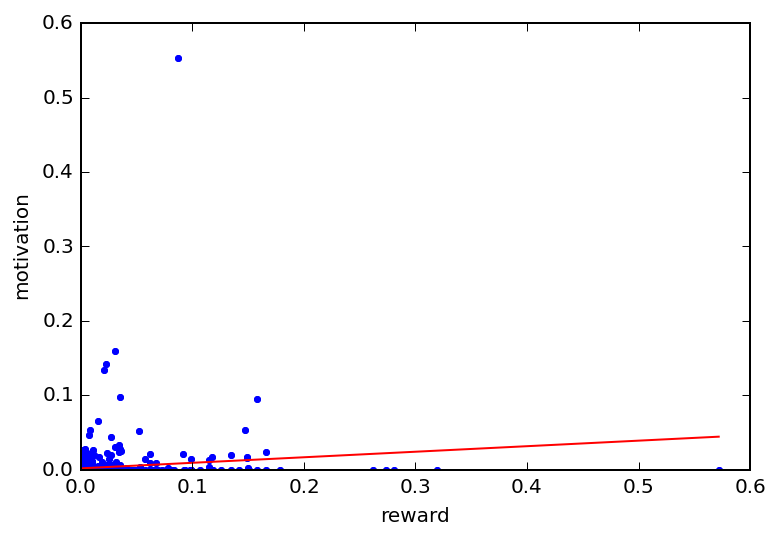

In [8]:
V.visualize_ns_ns(term1,term2)

### Correlating activation of one term with expression of one gene

(array([[ 1.        ,  0.06368729],
        [ 0.06368729,  1.        ]]),
 [0.0025777445159347288, 0.0033018573698162246])

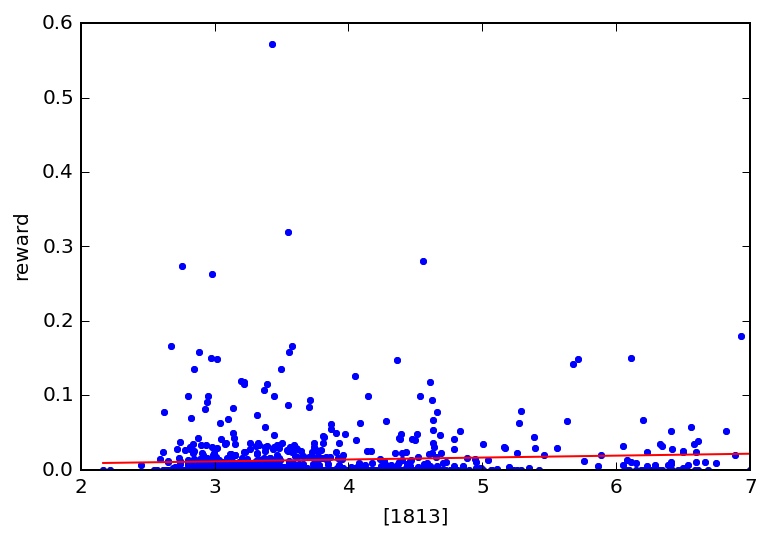

In [9]:
V.visualize_ns_ge('reward',[genes[0]])

We realized that linear correlations and regressions weren't capturing much of what was going on in the data so we built an analysis class to do more appropriate statistical analyses

# The Analysis Module

* t_test(term, gene, quant, log, graphops): performs a t-test on gene expression of given gene between papers that use that word and papers that don't. A significant t-test indicates that gene expression levels are significantly different. How much a word is used can be modulated with quant (0-1). if log is set to True, the t-test is performed on logged data. graphops can be set to 'density', 'violin', or 'box' to make different helpful plots.

* t_test_multi(term, quant, sample_num, genes_of_interest): performs t-tests on all (subsample sample_num) gene expression of all genes (that have been initialized) between papers that use a term and papers that don't (as defined by quant).

* p_val_distr(ttest_metrics): uses the output from t_test_multi and plots the distribution of p_values for every  for every term/non-term gene expression comparison

* effect_size_distr(ttest_metrics): uses the output from t_test_multi and plots the distribution of effect_sizes (cohen's d) for every term/non-term gene expression comparison. We believe the effect size  of the t-test will be more informative about significance than p value.

* fetch_gene_discriptions(ttest_metrics, nih_fetch_num, alpha): querries the NIH database of gene information and returns information about the top n genes. Prints new significance value after Bonferroni Correction using alpha



### Performing t-test on gene expression of D2 receptor in regions associated with reward and brain regions not associated with reward

To use inline plotting functionality in Jupyter, '%matplotlib inline' must be enabled
t-value: -3.6482 
p-value: 2.789E-04
Effect size: -0.3361 



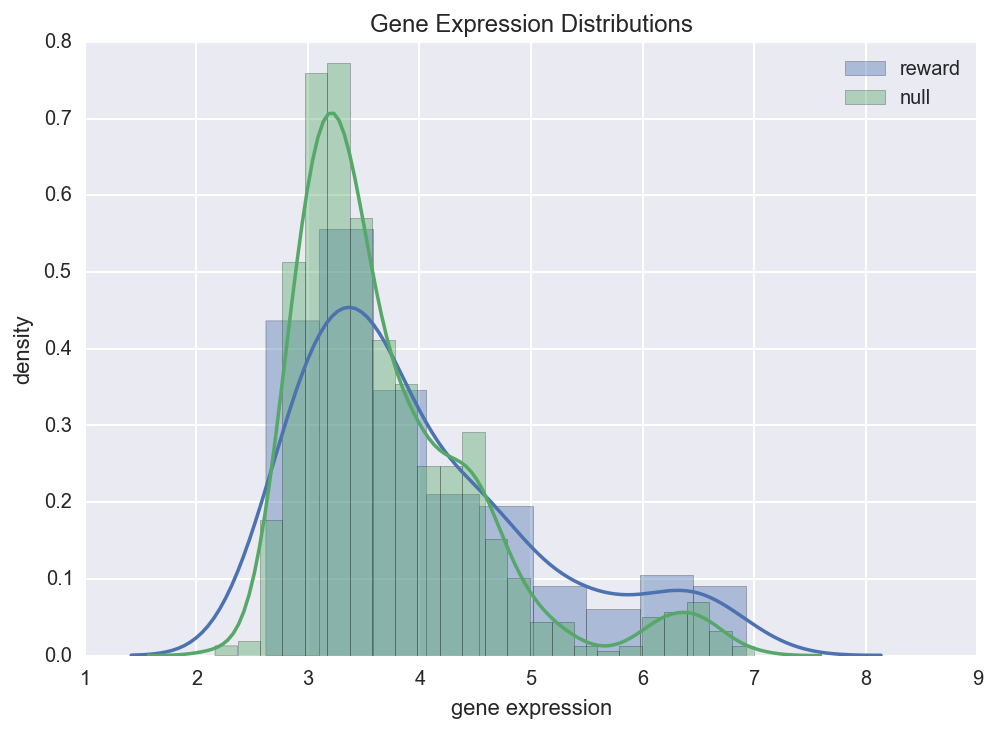

In [6]:
from nsaba.nsaba.analysis import NsabaAnalysis

A = NsabaAnalysis(N)
A.t_test('reward',genes[0],graphops='density')

t-value: -3.6482 
p-value: 2.789E-04
Effect size: -0.3361 



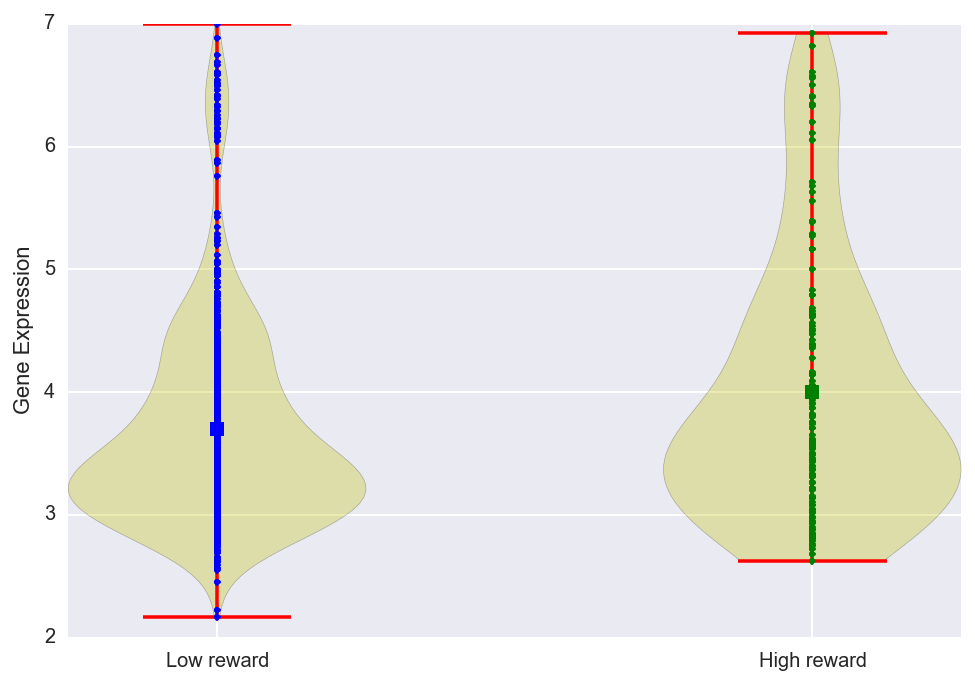

In [7]:
A.t_test('reward',genes[0],graphops='violin')

t-value: -3.6482 
p-value: 2.789E-04
Effect size: -0.3361 



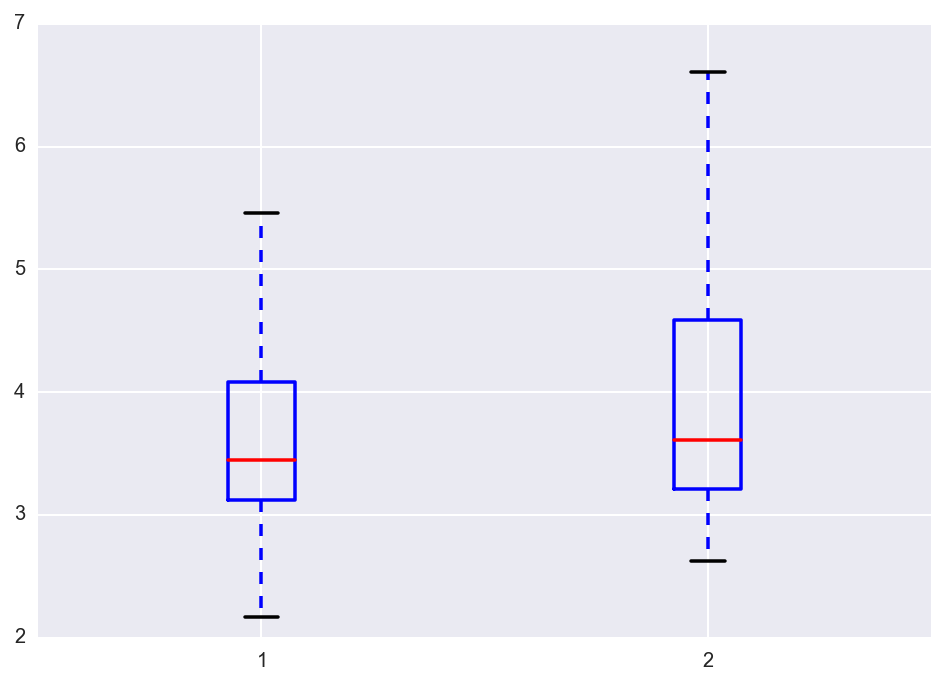

In [8]:
A.t_test('reward',genes[0],graphops='box')

### Performing t-tests on gene expression of *all genes* in regions associated with reward and brain regions not associated with reward

In [10]:
tttest_metrics = A.t_test_multi('reward',genes_of_interest=genes)

Gene: 6531  Effect Size: -0.365422924611
Gene: 1813  Effect Size: -0.336149155016


### Plotting effect size of all ttests

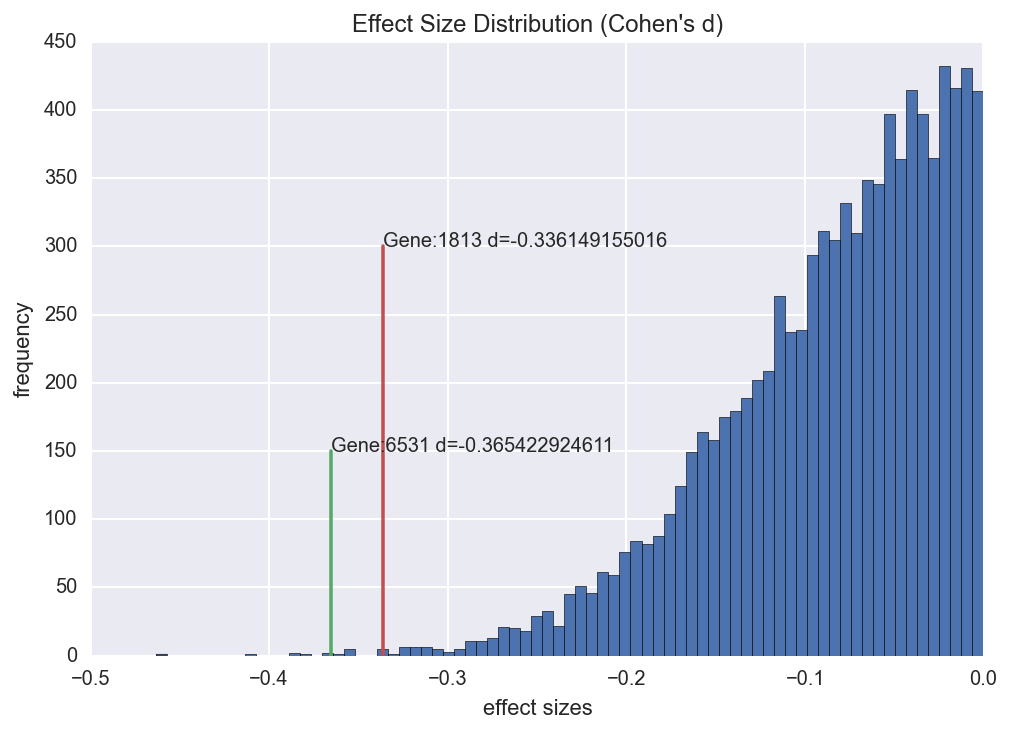

In [11]:
A.effect_size_distr(tttest_metrics,genes_of_interest=genes)

### In the cell below, we querry the NIH database for the top 20 genes found associated with reward.
## The 7th highest, out of 20,000 probes is the dopamine transporter and the 17th is the D2 receptor.


In [27]:
A.fetch_gene_descriptions(tttest_metrics)

Fetching NIH gene descriptions ...

Corrected Bonferroni Alpha: 2.405E-06


392197 (p = 6.069E-07; d = -0.463): inactive ubiquitin carboxyl-terminal hydrolase 17-like protein 7


341 (p = 8.972E-06; d = -0.411): The protein encoded by this gene is a member of the apolipoprotein C1 family. This gene is expressed primarily in the liver, and it is activated when monocytes differentiate into macrophages. A pseudogene of this gene is located 4 kb downstream in the same orientation, on the same chromosome. This gene is mapped to chromosome 19, where it resides within a apolipoprotein gene cluster. Alternatively spliced transcript variants have been found for this gene, but the biological validity of some variants has not been determined. [provided by RefSeq, Jul 2008]


886 (p = 3.360E-05; d = -0.384): This gene encodes a G-protein coupled receptor that binds non-sulfated members of the cholecystokinin (CCK) family of peptide hormones. This receptor is a major physiologic mediator of pancrea